Get the metrics per tile for all cnn models, which are in the folder reports/cnn/*/ and have the name testset_metrics_per_tile.csv.

Calculate average per tile

plot the average per tile on a map to find the best and worst tiles

In [34]:
import pandas as pd
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


In [15]:
DATASET = "data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg"
root = root + "/workspaces/mine-segmentation" # for lightning studios
DATASET = root + "/" + DATASET

In [17]:
# Get a list of all the csv files
csv_files = glob.glob('reports/cnn/*/testset_metrics_per_tile.csv')
csv_files

['reports/cnn/mineseg-cnn_epoch-03_val-iou-05003/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-10_val-iou-05356/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-13_val-iou-05376/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-15_val-iou-05171/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-16_val-iou-05201/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-16_val-iou-05703/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-16_val-iou-05731/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-16_val-iou-05847/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-18_val-iou-06038/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-21_val-iou-05594/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-21_val-iou-05826/testset_metrics_per_tile.csv',
 'reports/cnn/mineseg-cnn_epoch-15_val-iou-04971/testset_metrics_per_tile.csv']

In [18]:

# Read them into pandas dataframes and concatenate them
dfs = [pd.read_csv(file) for file in csv_files]
all_data = pd.concat(dfs)

In [22]:
# create tile column by extracting the first part of the file_name splitting by _
all_data['tile'] = all_data['file_name'].str.split('_').str[0]

# Calculate the average metrics per tile
average_iou = all_data.groupby('tile')["iou"].mean()
average_f1 = all_data.groupby('tile')["f1"].mean()

# create a geodataframe with the average metrics
average_metrics = pd.DataFrame({'tile_id': average_iou.index, 'iou': average_iou.values, 'f1': average_f1.values})
average_metrics

,tile_id,iou,f1
0,1030,0.688233,0.812451
1,1039,0.741998,0.846485
2,1051,0.319342,0.477699
3,1100,0.695048,0.815093
4,1201,0.697961,0.810249
...,...,...,...
111,891,0.629914,0.751034
112,924,0.424755,0.587295
113,933,0.481521,0.645639
114,939,0.672229,0.798313


In [44]:
# load the processed dataset
tiles = gpd.read_file(DATASET, layer="tiles")
test_tiles = tiles[tiles["split"] == "test"]

# convert to int to match the average_metrics
test_tiles["tile_id"] = test_tiles["tile_id"].astype(int)
average_metrics["tile_id"] = average_metrics["tile_id"].astype(int)

# join the average metrics with the test tiles
test_tiles = test_tiles.merge(average_metrics, on="tile_id")
print(test_tiles.shape[0])

116


/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


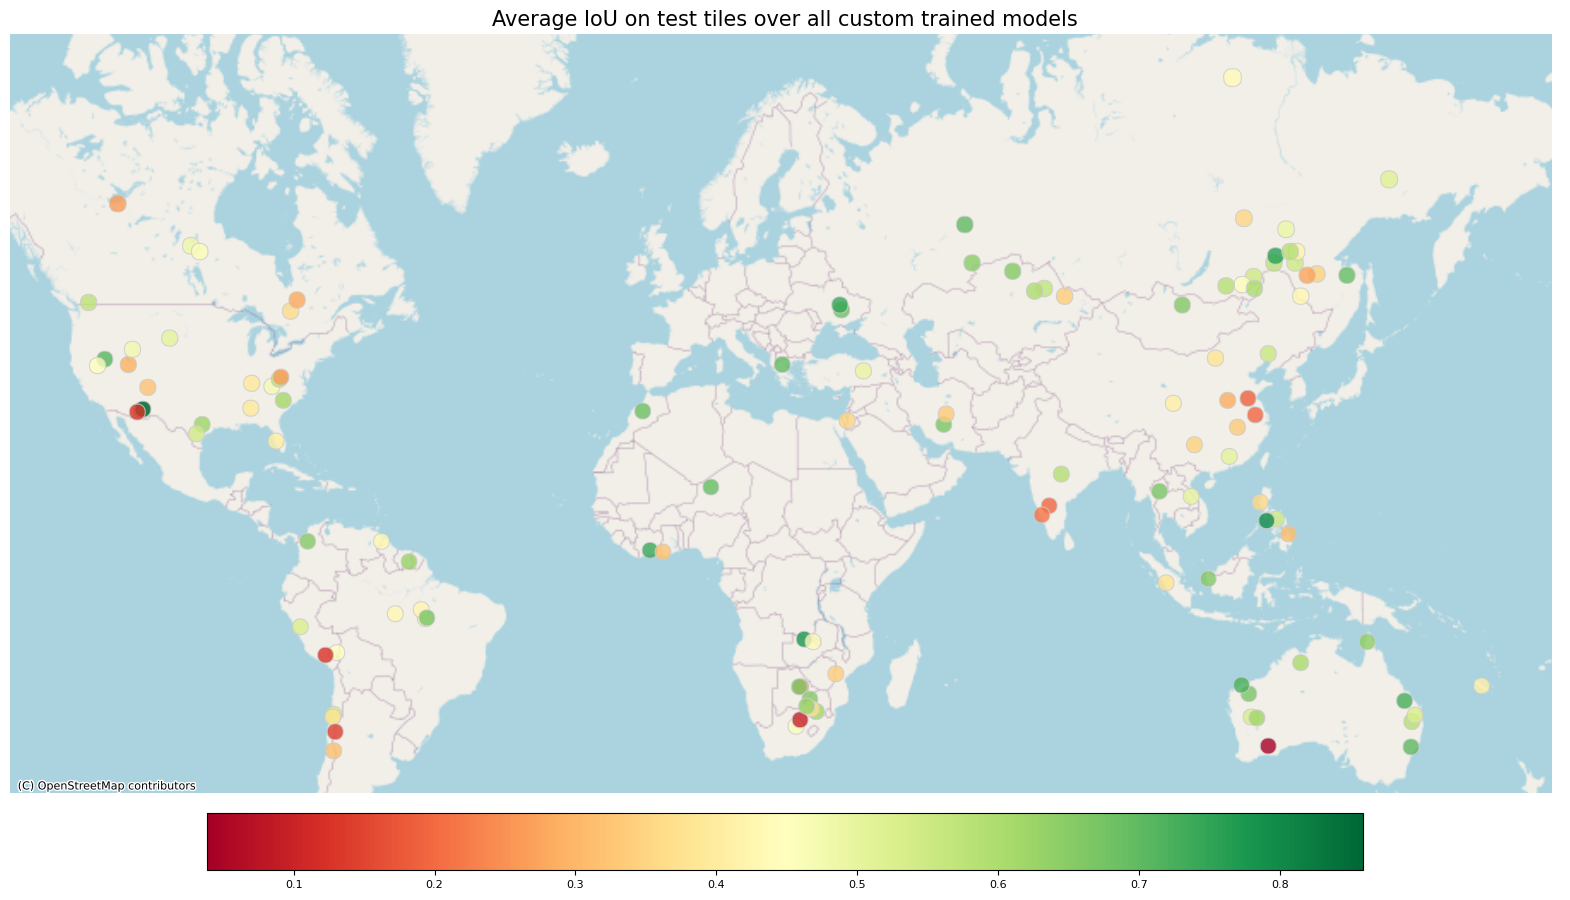

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20, 25))

# Assuming test_tiles is your GeoDataFrame
test_tiles = test_tiles.set_crs(epsg=4326)

# Convert the GeoDataFrame to Web Mercator projection (EPSG:3857)
test_tiles = test_tiles.to_crs(epsg=3857)

plot_df = test_tiles.copy()

# Buffer the polygons to increase their size
plot_df['geometry'] = plot_df.geometry.buffer(170000)

# Plot the GeoDataFrame
plot_df.plot(column='iou', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.8)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.axis('off')
ax.set_title('Average IoU on test tiles over all custom trained models', fontdict={'fontsize': '15', 'fontweight' : '3'})

# Create a colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min(plot_df['iou']), vmax=max(plot_df['iou'])))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.03, pad=0.01)
cbar.ax.tick_params(labelsize=8)  # set the size of the colorbar labels

add_tile_id = False
if add_tile_id: 
    # Annotate each geometry with the label from the specified column
    for idx, row in plot_df.iterrows():
        centroid = row['geometry'].centroid
        ax.annotate(
            text=row["tile_id"], 
            xy=(centroid.x, centroid.y), 
            xytext=(5, 5),  # shift annotation to the top right
            textcoords='offset points', 
            horizontalalignment='center', 
            fontsize=8, 
            color='black',
            rotation=45  # angle the text by 45 degrees
        )
plt.show()

In [ ]:
# get the 10 best and 10 worst tiles in terms of iou
best_tiles = test_tiles.sort_values(by='iou', ascending=False).head(10)
worst_tiles = test_tiles.sort_values(by='iou', ascending=True).head(10)

In [52]:
print(list(best_tiles.tile_id))
print(list(worst_tiles.tile_id))

[180, 2556, 1263, 2604, 1431, 1039, 2918, 2322, 62, 2952]
[2574, 1245, 167, 441, 504, 2397, 1647, 2480, 1635, 1248]
